## 赛题描述 ##

对于各大电商平台而言，良好的物流体验是提升用户满意度的一个重要手段。而准确预估订单的送达时间，不仅可以为用户下单提供有效决策，也可以让用户提前感知，合理规划收货时间。我们把如何准确预估每笔订单的送达时间，定义为订单物流时效预测问题。

该问题的主要挑战是整个订单的履约流程较长，不仅涉及到下单-发货-揽件-走件-签收等多个环节，而且每个环节影响的因素也截然不同。同时，由于订单天然存在密度差异性，因此无论是从商家还是物流公司还是消费者（收货地）角度看，数据都不可避免地存在不平衡问题。因此本次大赛需要选手综合运用数学建模，模型设计，数据挖掘等多种技术手段，从而构建出高精度的算法模型，提升订单物流时效预测的精度。

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# 读入文件，先把主要的支付时间转换为相应类型
train = pd.read_csv("SeedCup_pre_train.csv","\t")
test = pd.read_csv("SeedCup_pre_test.csv","\t")

In [2]:
train.head()

,uid,plat_form,biz_type,create_time,payed_time,product_id,cate1_id,cate2_id,cate3_id,preselling_shipped_time,...,lgst_company,warehouse_id,shipped_prov_id,shipped_city_id,rvcr_prov_name,rvcr_city_name,shipped_time,got_time,dlved_time,signed_time
0,956745,2,4,2019-03-01 14:45:27,2019-03-01 14:45:37,24309,16,237,261,0,...,6,10,0,60,30,26,2019-03-01 15:33:08,2019-03-01 20:10:28,2019-03-01 21:00:36,2019-03-03 15:32:50
1,306593,2,5,2019-03-01 06:58:05,2019-03-01 06:58:22,40130,22,162,824,2019-03-05 00:00:00,...,7,10,21,92,26,228,2019-03-05 18:13:49,2019-03-06 13:10:05,2019-03-07 09:28:20,2019-03-11 18:16:54
2,867154,2,5,2019-03-01 11:10:29,2019-03-01 11:11:02,41591,22,162,824,2019-03-05 00:00:00,...,10,10,1,50,25,54,2019-03-01 19:08:32,2019-03-02 14:22:26,2019-03-02 21:20:12,2019-03-04 13:50:55
3,1235035,2,4,2019-03-02 12:11:08,2019-03-02 12:11:18,40989,16,236,260,0,...,6,10,1,50,0,185,2019-03-02 15:52:37,2019-03-03 20:20:14,2019-03-03 20:50:26,2019-03-05 17:12:30
4,353513,2,5,2019-03-01 14:02:20,2019-03-01 14:02:45,41591,22,162,824,2019-03-05 00:00:00,...,9,10,1,50,5,266,2019-03-02 15:36:42,2019-03-03 14:18:55,2019-03-04 11:20:05,2019-03-08 18:28:05


## 评价标准 ##

误差率 rankScore = MSE(real_signed_time ,pred_signed_time ) 精确到小时<br>
准时率 onTimePercent = Count(pred_singed_date <= real_signed_date) 精确到天<br>
解释：本次评分考虑两个因子，一方面考虑到货时间均方根误差，另外一个就是考虑是否有天级别延迟。排名首先要求准时率>=98%,在此基础上对误差率进行排名。

## 变量说明 ##

字段|数据类型|备注
:-:|:-:|:-:
uid买家id|int	
plat_form交易平台|int|贝贝/贝店/贝仓...
biz_type业务来源|int|不同业务线售卖
create_time订单创建时间|string yyyy-MM-dd hh:mm:ss|
payed_time订单支付时间|string yyyy-MM-dd hh:mm:ss|
product_id商品id|int|
cate1_id商品类目1级|int|
cate2_id商品类目2级|int|
cate3_id商品类目3级|int|
preselling_shipped_time预售发货时间|string yyyy-MM-dd hh:mm:ss|存在噪声数据
seller_uid商家id|int|
company_name商家公司id|int|
lgst_company物流公司id|int|  
warehouse_id仓库id|int|  
shipped_prov_id 发货省份id|int| 
shipped_city_id 发货城市id|int|
rvcr_prov_name 收货省份id|int|
rvcr_city_name 收货城市id|int|
shipped_time 发货时间|string yyyy-MM-dd hh:mm:ss|取决于商家填写（可能存在延迟）
got_time 揽件时间|string yyyy-MM-dd hh:mm:ss|取决于物流公司信息（可能存在延迟）
dlved_time 走件时间|string yyyy-MM-dd hh:mm:ss|
signed_time 签收时间|string yyyy-MM-dd hh:mm:ss|

In [5]:
# Exploring the data using pandas methods : 'shape', 'info', 'describe', 'dtype', 'mean()', ...
print(f"DataFrame shape : \n{train.shape}\n=================================")
print(f"DataFrame info : \n{train.info()}\n=================================")
print(f"DataFrame columns : \n{train.columns}\n=================================")
print(f"各列的类型: \n{train.dtypes}\n=================================")
print(f"各列缺失值: \n{train.isna().sum()}\n=================================")

DataFrame shape : 
(373877, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373877 entries, 0 to 373876
Data columns (total 22 columns):
uid                        373877 non-null int64
plat_form                  373877 non-null int64
biz_type                   373877 non-null int64
create_time                373877 non-null object
payed_time                 373877 non-null object
product_id                 373877 non-null int64
cate1_id                   373877 non-null int64
cate2_id                   373877 non-null int64
cate3_id                   373877 non-null int64
preselling_shipped_time    373877 non-null object
seller_uid                 373877 non-null int64
company_name               373877 non-null int64
lgst_company               373877 non-null int64
warehouse_id               373877 non-null int64
shipped_prov_id            373877 non-null int64
shipped_city_id            373877 non-null int64
rvcr_prov_name             373877 non-null int64
rvcr_city_name       

一个缺失值也没有，建模就不太困难，但需要进行异常值的处理

## 预测目标—物流时效的探索性分析 ##

可以参照物流时效的准确定义，加上对模型预测最终结果的探究，签收和支付间隔的小时数就是我们需要预测的目标。注意，我们这里将进行一次筛选，选取所有天数大于等于0的行。

In [6]:
train['payed_time'] = pd.to_datetime(train['payed_time'],format='%Y-%m-%d %H:%M:%S')
test['payed_time'] = pd.to_datetime(test['payed_time'],format='%Y-%m-%d %H:%M:%S')

train['signed_time'] = pd.to_datetime(train['signed_time'],format='%Y-%m-%d %H:%M:%S')
train['y'] = train['signed_time'] - train['payed_time']
train['y_days'] = train['y'].dt.days
train = train[train['y_days'] >= 0]
train['y_hours'] = train['y'].dt.seconds / 3600 + train['y_days'] * 24
train['y_hours'] = np.around(train['y_hours'], decimals=2)
y_train_ = train['y_hours']

这里可以查看一下我们所要预测的y的某些特征：

In [7]:
train.y_hours.describe()

count    373847.000000
mean        103.260519
std          62.270686
min           1.540000
25%          61.990000
50%          80.700000
75%         127.170000
max         758.160000
Name: y_hours, dtype: float64

这个是前10的天数分布，可以看见天数分布较为集中

In [8]:
train.y_days.value_counts().head(10)

2     109711
3      80984
4      37664
1      37252
5      26462
6      19688
7      18054
8      15653
9      10703
10      7505
Name: y_days, dtype: int64

## 特征工程 ##

这个版本的特征工程只是将属性转换为能被模型接受的，然后再喂给它。要注意时间等维度的异常值，以及异常的时间，当出现类似于1970年这样的异常值时也要进行相应的处理，对于预售类的，可以笼统地直接分为预售商品和非预售商品，这里将有类似异常的数据的预售数据全都视为没有预售的商品。

先要将训练集和测试集和在一起，才能开始以下工作，可以发现共有47万多条数据。

In [9]:
data = pd.concat([train,test],axis=0,ignore_index=True)
data.shape

(473847, 25)

In [10]:
data['preselling_shipped_time'][data['preselling_shipped_time'] == "0"] = "1970-01-01 00:00:00"
data['preselling_shipped_time'] = pd.to_datetime(data['preselling_shipped_time'],format='%Y-%m-%d %H:%M:%S')
data['presell'] = data['preselling_shipped_time'].map(lambda x: 0 if x.year < 2019 else 1)

其实这个分类有点粗糙，只考虑了年份在2019年之前的异常结果，具体出现预售时间比发货时间还要晚的（可能是假预售）商品，也有可能影响结果。不过经过对预售与否的方法的各种优化，发现该方法结果已经很不错了，但仍有不小的优化空间。

我们可以看看这些预售与否的商品的描述，它们运输时间的差别还是存在比较大的差别的：

In [11]:
data[data['presell'] == 1].y_hours.describe()

count    128585.00000
mean        161.42379
std          65.64575
min          18.06000
25%         116.94000
50%         159.11000
75%         207.08000
max         758.16000
Name: y_hours, dtype: float64

In [12]:
data[data['presell'] == 0].y_hours.describe()

count    245262.000000
mean         72.766908
std          30.786877
min           1.540000
25%          53.280000
50%          69.080000
75%          87.800000
max         699.960000
Name: y_hours, dtype: float64

对于商品id，商品类目1级、2级、3级，商家id（这个和商家公司id相关度很高），笼统取前一些位置，和前面有关的各分为一类，剩下的其它当作一类。其实id通常对建模没有太好的效果，但是对于商品而言，大体积类的商品很有可能运输时间长一些，需要订做的商品发货时间可能和支付时间相隔很长，这些都会影响到我们所需要预测的物流时效。

In [13]:
data.product_id.value_counts().head(3000).sum()

407959

In [14]:
data.cate1_id.value_counts().head(10).sum()

443161

In [15]:
data.cate2_id.value_counts().head(40).sum()

422172

In [16]:
data.cate3_id.value_counts().head(160).sum()

407874

In [17]:
data.seller_uid.value_counts().head(400).sum()

425562

这些差不多都在40万左右。

In [20]:
product_id_index = list(data.product_id.value_counts().head(3000).index)
cate1_id_index = list(data.cate1_id.value_counts().head(10).index)
cate2_id_index = list(data.cate2_id.value_counts().head(40).index)
cate3_id_index = list(data.cate3_id.value_counts().head(160).index)

data["product_id_x"] = data["product_id"].map(lambda x:product_id_index.index(x) if x in product_id_index else len(product_id_index))
data["cate1_id_x"] = data["cate1_id"].map(lambda x:cate1_id_index.index(x) if x in cate1_id_index else len(cate1_id_index))
data["cate2_id_x"] = data["cate2_id"].map(lambda x:cate2_id_index.index(x) if x in cate2_id_index else len(cate2_id_index))
data["cate3_id_x"] = data["cate3_id"].map(lambda x:cate3_id_index.index(x) if x in cate3_id_index else len(cate3_id_index))

seller_uid_index = list(data.seller_uid.value_counts().head(400).index)
data["seller_uid_x"] = data["seller_uid"].map(lambda x:seller_uid_index.index(x) if x in seller_uid_index else len(seller_uid_index))

剔除掉对物流时效关系不大的特征，以及大多数没有在测试样本里出现的特征，我们决定选举以下10项作为特征进行学习：

In [21]:
a = data[["product_id_x","cate1_id_x","cate2_id_x",
          "cate3_id_x","seller_uid_x","presell",
          "plat_form","biz_type","rvcr_prov_name","rvcr_city_name"]]
X_train_ = a[:train.shape[0]]
X_test_  = a[train.shape[0]:]
target_column = "y_hours"
feature_columns = list(X_test_.columns)

X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

可以查看它们的关系热力图：

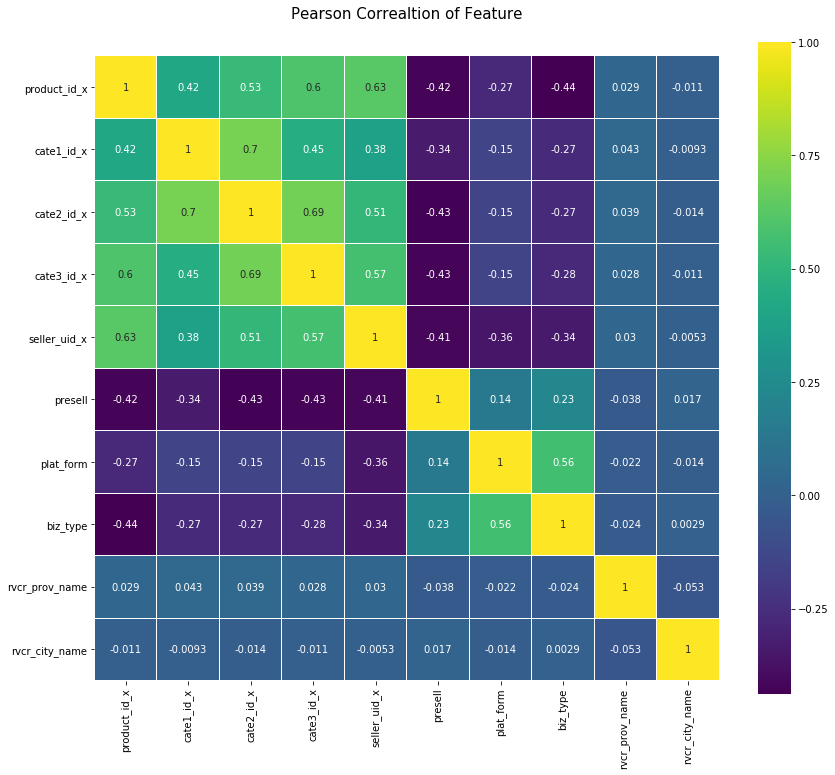

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Correlation = pd.DataFrame(data[["product_id_x","cate1_id_x","cate2_id_x",
                                 "cate3_id_x","seller_uid_x","presell","plat_form",
                                 "biz_type","rvcr_prov_name","rvcr_city_name"]])
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correaltion of Feature',y=1.05,size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

## 模型建立与求解 ##

由于我们选取的是树模型算法，不需要进行归一化或者one-hot编码等操作，可以直接将这些数据喂给模型。我们选取了xgboost、lightgbm、catboost三大著名提升树算法，进行模型的建立与求解，并将所有的结果写入文件。

In [23]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold

In [ ]:
#lgb
param = {'boosting_type': 'gbdt',
         'num_leaves': 32,
         'min_data_in_leaf': 100, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 50000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))


b = []
for i in predictions_lgb:
    b.append(pd.Timedelta(hours = i))
b = pd.Series(b)
test['ptime'] = test['payed_time'] + b
c = pd.DataFrame({'a':test['ptime'].dt.date.astype("str"),'b':test['ptime'].dt.hour.astype("str")})
c["b"] = c["b"].map(lambda x:x if len(x) == 2 else "0"+x)
c.to_csv("sample_result_lgb.txt",sep = " ",header = 0,index = 0)

In [ ]:
#xgb
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 7, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=100, verbose_eval=500, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))

b = []
for i in predictions_xgb:
    b.append(pd.Timedelta(hours = i))
b = pd.Series(b)
test['ptime'] = test['payed_time'] + b
c = pd.DataFrame({'a':test['ptime'].dt.date.astype("str"),'b':test['ptime'].dt.hour.astype("str")})
c["b"] = c["b"].map(lambda x:x if len(x) == 2 else "0"+x)
c.to_csv("sample_result_xgb.txt",sep = " ",header = 0,index = 0)

In [ ]:
#cat
kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 6,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))

b = []
for i in predictions_cb:
    b.append(pd.Timedelta(hours = i))
b = pd.Series(b)
test['ptime'] = test['payed_time'] + b
c = pd.DataFrame({'a':test['ptime'].dt.date.astype("str"),'b':test['ptime'].dt.hour.astype("str")})
c["b"] = c["b"].map(lambda x:x if len(x) == 2 else "0"+x)
c.to_csv("sample_result_cb.txt",sep = " ",header = 0,index = 0)

## 结果的分析和优化 ##

通过对之前的文件的提交以及对测试集上结果的分析，发现其rank_score能够接受，但是on_time_percent远远达不到要求。

tri()函数定义了读取文件时间的方法，我们可以对时间和日期进行分析。

In [ ]:
# 读取这三个算法出来的原始文件
def tri(a):
    b = pd.read_csv(a,header = None)
    b['d'] = pd.to_datetime(b[0],format='%Y-%m-%d %H')   
    test = pd.read_csv("SeedCup_pre_test.csv","\t")
    test['payed_time'] = pd.to_datetime(test['payed_time'],format='%Y-%m-%d %H:%M:%S')
    test['signed_time'] = pd.to_datetime(b[0],format='%Y-%m-%d %H')    
    test['y'] = test['signed_time'] - test['payed_time']
    test['y_days'] = test['y'].dt.days
    test = test[test['y_days'] >= 0]
    test['y_hours'] = test['y'].dt.seconds / 3600 + test['y_days'] * 24
    test['y_hours'] = np.around(test['y_hours'], decimals=2)    
    return test

test1 = tri("sample_result_cb.csv")
test1.y_hours.describe()
test1.signed_time.dt.date.value_counts()
test2 = tri("sample_result_lgb.csv")
test2.y_hours.describe()
test2.signed_time.dt.date.value_counts()
test3 = tri("sample_result_xgb.csv")
test3.y_hours.describe()
test3.signed_time.dt.date.value_counts()

结合baseline的结果和on_time_percent的定义和要求，我们决定对所预测的时间进行下列所述的机械性下降，历经简单的调整后，可以发现
on_time_percent正好达到0.98的要求，且rank_score不会有非常大的变化。

In [ ]:
a = pd.DataFrame({'a':test1.signed_time,'b':test2.signed_time,'c':test3.signed_time})
a['d'] = a.apply(lambda x:min(x.a,x.b,x.c),axis=1)
import datetime
import random
random.seed(2019)
def adjust(x):
    if x.hour >= 2:
        return datetime.datetime(x.year,x.month,x.day - 1,23)
    elif x.hour == 1:
        if random.random() > 0.5:
            return datetime.datetime(x.year,x.month,x.day - 1,23)
        else:
            return datetime.datetime(x.year,x.month,x.day - 2,23)
    else:    
        return datetime.datetime(x.year,x.month,x.day - 2,23)

a['e'] = a['d'].map(adjust)
c = pd.DataFrame({'a':a['e'].dt.date.astype("str"),'b':a['e'].dt.hour.astype("str")})
c["b"] = c["b"].map(lambda x:x if len(x) == 2 else "0"+x)
c.to_csv("sample_result.txt",sep = " ",header = 0,index = 0)

本方案的优化空间还有很大，至少存在以下几点：
+ 可以专门探究预售关系，制定更为严格的预售与否的标准。
+ 可以将每天的时间进行分段，作为一个重要的特征输入模型。
+ 可以进行真正的特征工程工作，筛选出真正有用的特征进行建模。或者增加一些有用的特征。
+ 可以自定义xgboost等算法中的代价函数，使其更加适合on_time_percent，模型原始的预测值就达到比较高的标准。
+ 可以改进最后的减少日期的算法，进行on_time_percent的提升，同时减少对rank_score的影响。